# Importing Libraries

In [4]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance,variance_decomposition_ex_post
from PnL_Computation import PnL
from Stock_Data import get_close
from Rebalancing import *
from Git import *

In [5]:
git=GitHub(token,repo_owner,repo_name,branch)
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

# Loading Benchmark

In [7]:
start_date=datetime.datetime(2020,1,1)
today=datetime.datetime.today()
days=(today-start_date).days
remaining=days%500
numbers_of_table=days//500
tickers=Binance.get_market_cap()['Ticker'].iloc[:40].to_list()
temp_end=start_date
scope_prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    scope_prices=scope_prices.combine_first(data)
    
temp_end=(today-datetime.timedelta(remaining))
data=Binance.get_price(tickers,temp_end)
scope_prices=scope_prices.combine_first(data)
scope_prices=scope_prices.sort_index()
scope_prices = scope_prices[~scope_prices.index.duplicated(keep='first')]
scope_prices.index=pd.to_datetime(scope_prices.index)
tickers2=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()
prices=scope_prices[tickers2]
returns=np.log(1+prices.pct_change(fill_method=None))
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na].sort_index()
dataframe=prices[with_no_na].sort_index()
dataframe.index=pd.to_datetime(dataframe.index)
returns_to_use.index=pd.to_datetime(returns_to_use.index)
returns_to_use = returns_to_use[~returns_to_use.index.duplicated(keep='first')]

month=list(sorted(set(returns_to_use.index + pd.offsets.BMonthEnd(0))))
#month_end=pd.to_datetime(mrat_wo_na.index)
month = pd.to_datetime(month)

idx1 = pd.Index(returns_to_use.iloc[:-1].index)
idx2 = pd.Index(month)
closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]

dates_end=list(closest_dates)
dates_end.insert(0,returns_to_use.index[1])
dates_end.append(returns_to_use.index[-1])
dates_end=sorted(list(set(dates_end)))
dates_end.pop(0)
dates_end=sorted(list(set(dates_end)))

results={}

if 'USDCUSDT' in returns_to_use.columns:
    
    cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

else:

    cash=[]
# gold_positions=np.where(returns_to_use.columns=='GOLD.PA')[0][0]
#om_limit=np.where(returns_to_use.columns=='OMUSDT')[0][0]

for i in range(len(dates_end)-1):
    
    try:
        dataset=returns_to_use.loc[dates_end[i]:dates_end[i+1]]        
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        
        optimal=risk.optimize(objective='minimum_variance',constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00}#,
                                                                       ])# {'type': 'eq', 'fun': lambda weights: weights[gold_positions]-0.00}])
        
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
        pass

rolling_optimization=pd.DataFrame(results,index=dataframe.columns).T
rolling_optimization.loc[dates_end[0]]=1/len(dataframe.columns)
rolling_optimization=rolling_optimization.sort_index()

performance_model=pd.DataFrame()

In [8]:
q=rebalanced_dynamic_quantities(dataframe,rolling_optimization.iloc[:-2])
results=q*dataframe

performance_model['Fund']=results.sum(axis=1)
performance_model['Bitcoin']=dataframe['BTCUSDT']
#performance['Mantra']=dataframe['OMUSDT']

performance_model_pct=performance_model.copy()
performance_model_pct=performance_model_pct.pct_change(fill_method=None)

# Importing Data

In [10]:
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [11]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [13]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [14]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [15]:
quantities_api=Binance.binance_api.user_asset()

current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [16]:
# trade_history=pd.read_excel('Trades USDT.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))

In [17]:
price=Pnl_calculation.get_trade_in_usdt(trade_history)

BTCUSDT 0
TRXUSDT 1
TRXUSDT 2
TRXUSDT 3
BTCUSDT 4
TRXUSDT 5
BNBUSDT 6
ETHUSDT 7
SOLUSDT 8
BNBUSDT 9
USDTTRY 10
JASMYUSDT 11
BNBUSDT 12
BBUSDT 13
USDTTRY 14
BNBUSDT 15
USDTTRY 16
TRXUSDT 17
USDTTRY 18
JASMYUSDT 19
BNBUSDT 20
BBUSDT 21
OMUSDT 22
OMUSDT 23
OMUSDT 24
TRXUSDT 25
BTCUSDT 26
OMUSDT 27
BTCUSDT 28
TRXUSDT 29
TRXUSDT 30
BBUSDT 31
BNBUSDT 32
TRXUSDT 33
BTCUSDT 34
TRXUSDT 35
BTCUSDT 36
MKRUSDT 37
BTCUSDT 38
MKRUSDT 39
EURUSDT 40
EURUSDT 41
BBUSDT 42
BNBUSDT 43
JASMYUSDT 44
PEPEUSDT 45
NOTUSDT 46
NOTUSDT 47
NOTUSDT 48
BBUSDT 49
BBUSDT 50
PEPEUSDT 51
JASMYUSDT 52
BTCUSDT 53
BTCUSDT 54
TRXUSDT 55
BTCUSDT 56
BNBUSDT 57
BTCUSDT 58
BNBUSDT 59
BTCUSDT 60
BNBUSDT 61
BTCUSDT 62
BNBUSDT 63
BTCUSDT 64
BNBUSDT 65
BNBUSDT 66
BTCUSDT 67
BNBUSDT 68
JASMYUSDT 69
JASMYUSDT 70
ENSUSDT 71
ARUSDT 72
BTCUSDT 73
UMAUSDT 74
BTCUSDT 75
UMAUSDT 76
ETHUSDT 77
XRPUSDT 78
BTCUSDT 79
XRPUSDT 80
BTCUSDT 81
NEARUSDT 82
BTCUSDT 83
LPTUSDT 84
BTCUSDT 85
NEARUSDT 86
EURUSDT 87
BTCUSDT 88
INJUSDT 89
BTCUSDT 90
FETU

In [18]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

historical_positions.rename(columns={'TRYUSDT': 'USDTTRY'}, inplace=True)

In [19]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_435608\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [20]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()


In [21]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:80].to_list()

In [22]:
holding=Binance.get_inventory()
last_prices=Binance.get_price(list(q.iloc[-1].keys()))

positions=pd.DataFrame(q.iloc[-1]*last_prices).T
positions['Weights Model']=positions[positions.columns]/positions[positions.columns].sum()

condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
holding_tickers.remove("USDCUSDT")
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,last_book_cost,holding.loc[condition],positions['Weights Model'],realized_pnl],axis=1)
pnl.columns=['Average Cost','Book Cost','Price in USDT','Weights','Weights Model','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Average Cost']=np.nan

pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100
pnl.sort_values(by='Weights',ascending=False).round(4)

,Average Cost,Book Cost,Price in USDT,Weights,Weights Model,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,NaN,1979.7492,2164.0063,0.9999,1.0000,-28.6129,212.87,184.2571,9.3071
BTCUSDT,74833.4149,911.2802,1452.9529,0.6714,0.7064,13.0697,541.67,554.7397,28.0207
TRXUSDT,0.2647,512.9871,638.5342,0.2951,0.2936,80.2793,125.55,205.8293,10.3967
OMUSDT,1.1299,526.3213,71.9203,0.0332,0.0000,0.0000,-454.40,-454.4000,-22.9524
USDCUSDT,0.0000,0.0000,0.3227,0.0001,0.0000,0.0000,0.00,0.0000,0.0000
ETHUSDT,3654.5327,0.1328,0.1499,0.0001,0.0000,55.9949,0.02,56.0149,2.8294
NEARUSDT,8.2727,0.0000,0.0000,0.0000,0.0000,-10.3233,0.00,-10.3233,-0.5214
NOTUSDT,0.0196,0.0000,0.0000,0.0000,0.0000,1.0078,0.00,1.0078,0.0509
XLMUSDT,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000
BCHUSDT,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000


In [23]:
selling_amount=pd.DataFrame()

selling_amount['Portfolio']=pnl['Weights']
selling_amount['Model']=pnl['Weights Model']
selling_amount['Positions']=pnl['Price in USDT']

selling_amount['Model Positions']=selling_amount['Model']*selling_amount.loc['Total','Positions']
selling_amount['Spread']=selling_amount['Model Positions']-selling_amount['Positions']
selling_amount.sort_values(by='Model',ascending=False).round(2)

,Portfolio,Model,Positions,Model Positions,Spread
Total,1.00,1.00,2164.01,2164.01,0.00
BTCUSDT,0.67,0.71,1452.95,1528.59,75.64
TRXUSDT,0.30,0.29,638.53,635.41,-3.12
PEPEUSDT,0.00,0.00,0.00,0.00,-0.00
XLMUSDT,0.00,0.00,0.00,0.00,0.00
BCHUSDT,0.00,0.00,0.00,0.00,0.00
LINKUSDT,0.00,0.00,0.00,0.00,0.00
ADAUSDT,0.00,0.00,0.00,0.00,0.00
DOGEUSDT,0.00,0.00,0.00,0.00,0.00
USDCUSDT,0.00,0.00,0.32,0.00,-0.32


In [24]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [25]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [26]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [27]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')
inventory_weights.pop('USDCUSDT')


if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [28]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [29]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [31]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: bc9fccce02983844d8ed9b9fb540b130ed8c7ad1)
✅ File pushed/updated successfully!


In [32]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [33]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [34]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [35]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: f4a7ca7fb0fd81360fe9425553fad58dd9b84aa8)
✅ File pushed/updated successfully!


In [36]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [37]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [38]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()
cols=quantities.columns[quantities.columns!='USDCUSDT']

for col in cols:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index] 

In [39]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [40]:
# pnl_history['Total']

In [41]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [42]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [43]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [44]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in cols:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [45]:
pnl_history['Total']

2024-09-23   -247.226270
2024-09-24   -303.288508
2024-09-25   -320.535015
2024-09-26   -234.835798
2024-09-27   -218.316677
                 ...    
2025-10-05   -230.585848
2025-10-06   -203.038420
2025-10-07   -265.912942
2025-10-08   -233.095508
2025-10-09    260.704609
Name: Total, Length: 382, dtype: float64

<Axes: >

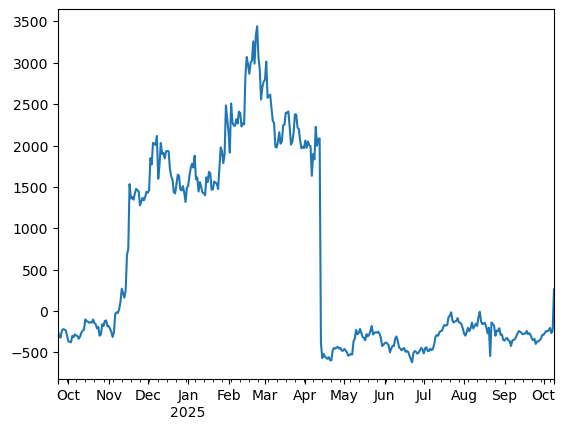

In [46]:
pnl_history['Total'].plot()

In [47]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl[-31:]

2025-09-09      7.514311
2025-09-10     32.069894
2025-09-11     38.330067
2025-09-12     28.157845
2025-09-13     -9.210608
2025-09-14    -12.518451
2025-09-15    -17.024334
2025-09-16      7.182172
2025-09-17      1.849051
2025-09-18     29.806058
2025-09-19    -37.805603
2025-09-20     10.375811
2025-09-21    -18.452314
2025-09-22    -45.323121
2025-09-23    -20.406501
2025-09-24     17.724228
2025-09-25    -61.920400
2025-09-26     29.559911
2025-09-27      0.855447
2025-09-28     14.379318
2025-09-29     18.308190
2025-09-30     44.140745
2025-10-01      2.513205
2025-10-02     25.932412
2025-10-03     19.426799
2025-10-04     -3.164062
2025-10-05     14.336500
2025-10-06     27.547427
2025-10-07    -62.874522
2025-10-08     32.817434
2025-10-09    493.800117
Name: Total, dtype: float64

In [48]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']

var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-366.8156499387816, -950.5160328166937)

In [49]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [50]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [51]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [52]:
start_date=datetime.datetime(2024,5,11)
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(weights_ex_post.columns,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(weights_ex_post.columns,temp_end)
binance_data=prices.combine_first(last_data)
binance_data=binance_data.sort_index()
binance_data = binance_data[~binance_data.index.duplicated(keep='first')]
binance_data.index=pd.to_datetime(binance_data.index)

LDUMAUSDT not retrieved
Total not retrieved
LDUMAUSDT not retrieved
Total not retrieved
LDUMAUSDT not retrieved
Total not retrieved


In [53]:
binance_data=np.log(1+binance_data.pct_change())

C:\Users\niroo\AppData\Local\Temp\ipykernel_435608\2713676895.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [54]:
weight_date=set(weights_ex_post.index)
binance_date=set(binance_data.index)

In [55]:
common_date=weight_date.intersection(binance_date)

In [56]:
binance_data2=binance_data.loc[list(common_date)].copy().sort_index()
weights_ex_post2=weights_ex_post.loc[list(common_date)].copy().sort_index()

In [57]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post2[col]*binance_data2[col]
    

In [58]:
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

In [59]:
variance_decomposition=variance_decomposition_ex_post(quantities.fillna(0).loc['2025-09':],price_pnl.loc['2025-09':])
variance_decomposition_pct=variance_decomposition.copy()
total_var=variance_decomposition['Variance'].sum()
for col in variance_decomposition_pct.columns:
    variance_decomposition_pct[col]=variance_decomposition[col]/total_var

In [60]:
variance_decomposition_pct.round(4)

,Variance,Correlation,Idiosyncratic
BNBUSDT,0.0000,0.0000,0.0000
BTCUSDT,0.4488,0.1045,0.3443
ETHUSDT,0.0001,0.0001,0.0000
OMUSDT,0.0510,0.0348,0.0162
PEPEUSDT,0.0000,0.0000,0.0000
SOLUSDT,0.0001,0.0001,0.0000
TRXUSDT,0.5001,0.0975,0.4026
USDCUSDT,-0.0000,-0.0000,0.0000
BBUSDT,0.0000,0.0000,0.0000
JASMYUSDT,0.0000,0.0000,0.0000


<Axes: >

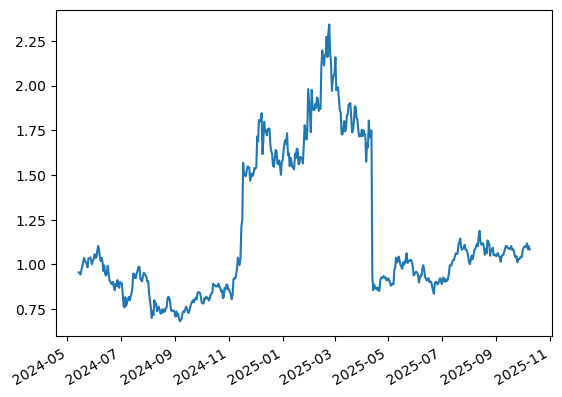

In [61]:
(1+historical_ptf['Historical Portfolio']).cumprod().plot()

In [62]:
(1+historical_ptf['Historical Portfolio'].loc['2025-08-30':]).cumprod()*100

2025-08-30    100.353789
2025-08-31    100.051951
2025-09-01     99.535062
2025-09-02    100.710311
2025-09-03    101.129679
2025-09-04     99.485482
2025-09-05     99.220782
2025-09-06     96.554921
2025-09-07     99.424509
2025-09-08    100.075140
2025-09-09    100.234767
2025-09-10    101.796175
2025-09-11    103.608254
2025-09-12    104.995500
2025-09-13    104.842955
2025-09-14    103.865797
2025-09-15    103.865797
2025-09-16    103.281206
2025-09-17    103.568122
2025-09-18    104.921080
2025-09-19    102.921338
2025-09-20    103.359550
2025-09-21    102.378707
2025-09-22     99.769367
2025-09-23     98.889202
2025-09-24     99.572478
2025-09-25     96.315933
2025-09-26     97.867406
2025-09-27     97.842644
2025-09-28     98.567105
2025-09-29     99.249159
2025-09-30     98.997365
2025-10-01    102.626041
2025-10-02    103.907215
2025-10-03    104.714896
2025-10-04    104.352599
2025-10-05    104.822214
2025-10-06    106.367034
2025-10-07    103.113320
2025-10-08    104.743925


## Ex ante data

In [64]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [67]:
days=120
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [68]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]#,np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold=np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [71]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00},
                                                                           {'type': 'eq', 'fun': lambda weights: 0.00-weights[gold]}])#,
                                                                              
                                                                              #{'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
BNBUSDT,0.8097
ZECUSDT,0.1903
FDUSDUSDT,0.0000
TRXUSDT,0.0000
BCHUSDT,0.0000
BTCUSDT,0.0000
WBTCUSDT,0.0000
NEXOUSDT,0.0000
LTCUSDT,0.0000
WBETHUSDT,0.0000


In [72]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.0},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[gold]},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[cash]}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
BNBUSDT,0.809662
ZECUSDT,0.190338


In [73]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))

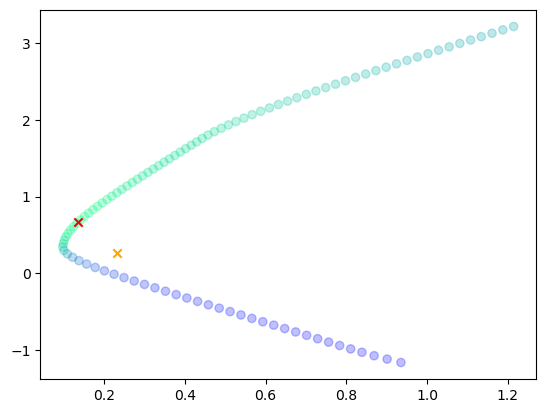

In [74]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [75]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [76]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1452.9529,0.6714,0.0000,0.6714
TRXUSDT,638.5342,0.2951,0.0183,0.2768
OMUSDT,71.9203,0.0332,0.0000,0.0332
USDCUSDT,0.3227,0.0001,0.0000,0.0001
ETHUSDT,0.1499,0.0001,0.0000,0.0001
SOLUSDT,0.0941,0.0000,0.0000,0.0000
BNBUSDT,0.0322,0.0000,0.0965,-0.0965
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
PAXGUSDT,0.0000,0.0000,0.7397,-0.7397
ZECUSDT,0.0000,0.0000,0.0490,-0.0490


### Current results

In [78]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

gold_current=np.where(ex_ante_perf_to_use.columns=='PAXGUSDT')[0][0]

In [79]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.00-weights[gold_current]}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BNBUSDT,0.886914
TRXUSDT,0.113086


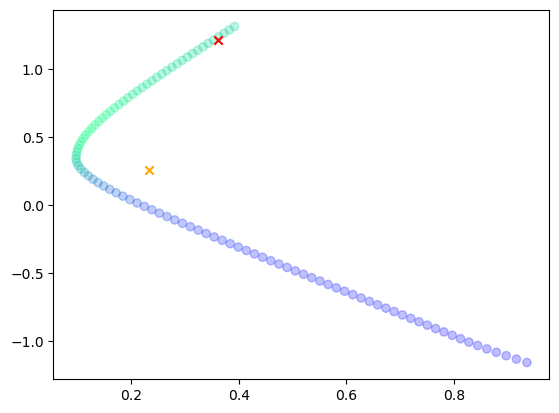

In [80]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [81]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1452.9529,0.6714,0.0000,0.6714
TRXUSDT,638.5342,0.2951,0.1131,0.1820
OMUSDT,71.9203,0.0332,0.0000,0.0332
USDCUSDT,0.3227,0.0001,0.0000,0.0001
ETHUSDT,0.1499,0.0001,0.0000,0.0001
SOLUSDT,0.0941,0.0000,0.0000,0.0000
BNBUSDT,0.0322,0.0000,0.8869,-0.8869
PEPEUSDT,0.0000,0.0000,0.0000,0.0000


# Risk Reward Analysis

In [83]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [84]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf
portfolio_perf['Model']=performance_model_pct['Fund']

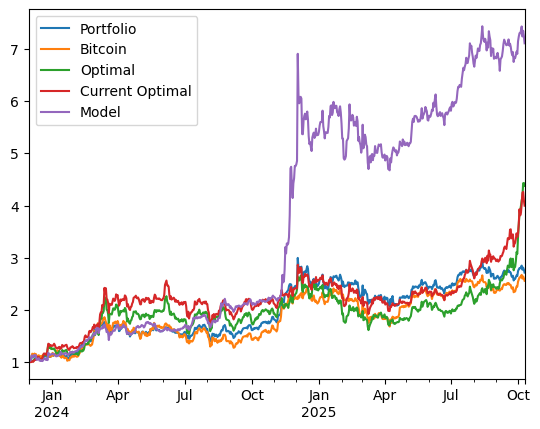

In [85]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [86]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

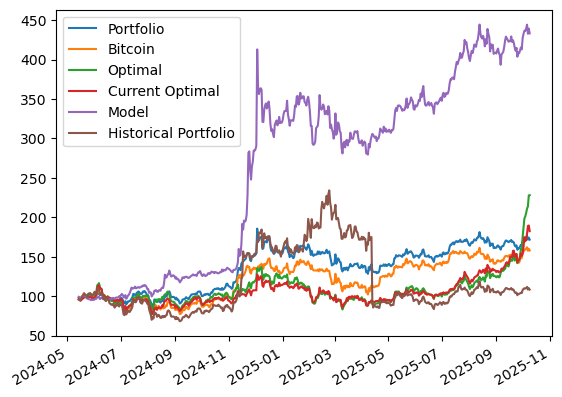

In [87]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


<Axes: >

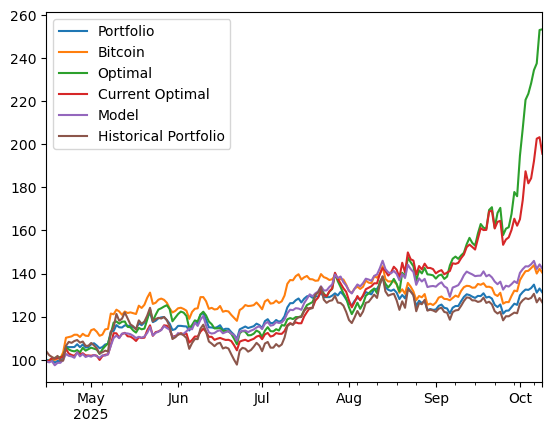

In [88]:
((1+current_perf.loc['2025-04-15':]).cumprod()*100).plot()

<Axes: >

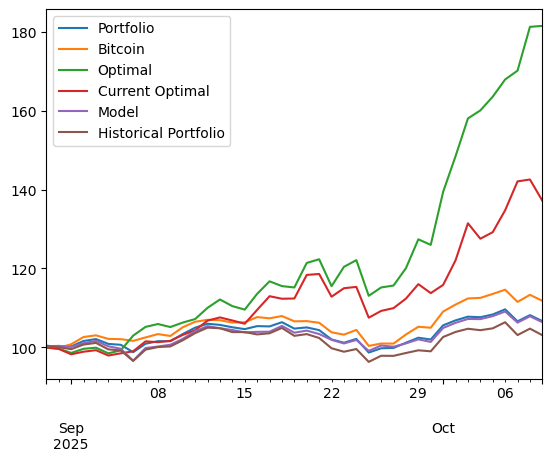

In [89]:
((1+current_perf.loc['2025-08-30':]).cumprod()*100).plot()

In [90]:
((1+current_perf.loc['2025-09':]).cumprod()*100)

,Portfolio,Bitcoin,Optimal,Current Optimal,Model,Historical Portfolio
2025-09-01,100.124689,100.911403,98.918426,98.630064,99.756866,99.483380
2025-09-02,101.500090,102.744604,99.963678,99.287254,100.671284,100.658019
2025-09-03,101.990775,103.173841,100.244445,99.675446,101.276947,101.077169
2025-09-04,100.763394,102.269505,98.809877,98.316431,99.878887,99.433826
2025-09-05,100.534917,102.204021,99.576476,98.876528,99.290841,99.169263
2025-09-06,98.667230,101.767137,103.312786,99.392512,96.253927,96.504786
2025-09-07,100.804242,102.640198,105.543609,101.918556,99.459434,99.372884
2025-09-08,101.450504,103.493588,106.268900,101.719463,99.837152,100.023178
2025-09-09,101.459414,103.013320,105.501253,102.048727,100.280858,100.182721
2025-09-10,103.254886,105.218521,106.638679,103.562664,101.762696,101.743319


## Volatilities

In [92]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.419975
 dtype: float64,
 0.41997481468792325)

In [93]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.233112
 dtype: float64,
 0.23311180063541026)

In [94]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.364367
Bitcoin            0.397820
Optimal            0.446339
Current Optimal    0.420892
Model              0.483408
dtype: float64

In [95]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.18558739349185632

In [96]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

1.0775266331837414

<Axes: >

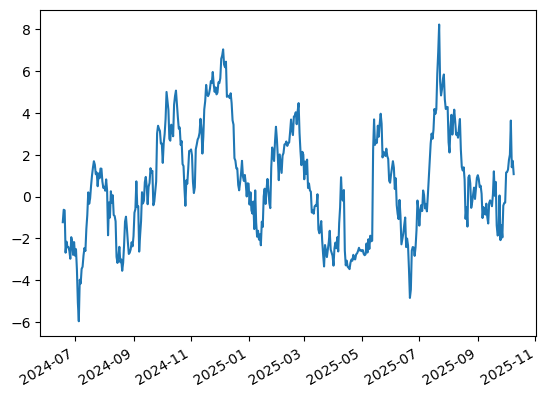

In [97]:
window=30
rolling_sharpe_ratio=current_perf['Historical Portfolio'].rolling(window).mean()*252/(current_perf['Historical Portfolio'].rolling(window).std()*np.sqrt(252))
rolling_sharpe_ratio.plot()

In [98]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

1.114511482760725

## Risk Contribution

In [100]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,64.7756,0.6346,0.5721,0.0625
ZECUSDT,45.1754,0.3654,0.3029,0.0625
Portfolio,109.9510,1.0000,0.8750,0.1250


In [101]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,70.955990,0.962013,0.930974,0.031039
TRXUSDT,2.188387,0.037987,0.006948,0.031039
Portfolio,73.144376,1.000000,0.937922,0.062078


In [102]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,7.676296,0.669939,0.494893,0.175046
TRXUSDT,5.805458,0.264543,0.117038,0.147505
OMUSDT,-1.575744,0.065518,0.014484,0.051034
Portfolio,11.906009,1.000000,0.626414,0.373586


# Value At Risk

## Historical

### Optimal Weights

In [106]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.054334843539828176, -0.0649566091529323)

### Current Weights

In [108]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.03458714577844223, -0.03702604083029237)

In [109]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [110]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.027798
TRXUSDT     -0.003836
OMUSDT      -0.003121
ETHUSDT     -0.000000
SOLUSDT     -0.000000
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
PAXGUSDT    -0.000000
Portfolio   -0.034755
Name: 2025-08-14 00:00:00, dtype: float64

In [111]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.024032
TRXUSDT     -0.010326
OMUSDT      -0.002668
ETHUSDT      0.000000
SOLUSDT      0.000000
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.037026
dtype: float64

## Parametric

### Optimal Weights

In [114]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.061545688567054606, -0.0762283613427629)

### Current Weights

In [116]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.03416163489201926, -0.042311419520007575)

## Multivariate

### Optimal Weights

In [119]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05546151222219064, -0.06249348437640692)

### Current Weights

In [121]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.033154226939267985, -0.038555330104505486)

In [122]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

BTCUSDT     -0.022466
TRXUSDT     -0.008325
OMUSDT      -0.002241
Portfolio   -0.033031
dtype: float64

In [123]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

BTCUSDT     -0.023495
TRXUSDT     -0.007664
OMUSDT      -0.002285
Portfolio   -0.033445
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [127]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0544514928396075, -0.06347552735828599)

### Current Weights

In [129]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0334224731554674, -0.039136232695404484)

In [130]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [133]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.054010272772143965, -0.06250820220592627)

### Current Weights

In [135]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.03450893649251869, -0.03943958601687337)

In [136]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [139]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.13276412978068694, -0.1679572295355313)

### Current Weights

In [141]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06546104319402148, -0.08010253225391414)

In [142]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [145]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [146]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.061921531995094904, -0.0709031638318156)

### Current Weights

In [148]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.033762814605504794, -0.038803963133031125)

In [149]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [150]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.032613,-0.022731,-0.016579,-0.022466,-0.022499
TRXUSDT,-0.006975,-0.007658,-0.006140,-0.008325,-0.009553
OMUSDT,-0.000934,-0.002654,-0.001686,-0.002241,-0.002274
Portfolio,-0.040522,-0.033042,-0.024406,-0.033031,-0.034325


In [151]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.034236,-0.023205,-0.017159,-0.023495,-0.022808
TRXUSDT,-0.005580,-0.007495,-0.005972,-0.007664,-0.009878
OMUSDT,-0.001275,-0.002769,-0.001531,-0.002285,-0.002103
Portfolio,-0.041091,-0.033469,-0.024662,-0.033445,-0.034788


## VaR Violation

In [153]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.041170,-0.069654,-0.063418,-0.012635
2024-01-15,-0.041170,-0.072931,-0.067118,0.054810
2024-01-16,-0.041170,-0.072368,-0.068076,-0.009627
2024-01-17,-0.041170,-0.073030,-0.069508,-0.017184
2024-01-18,-0.041170,-0.072234,-0.069811,0.005846
...,...,...,...,...
2025-10-06,-0.068794,-0.081949,-0.065152,0.026683
2025-10-07,-0.068794,-0.081938,-0.063671,0.013356
2025-10-08,-0.068794,-0.084339,-0.066823,0.065238
2025-10-09,-0.068794,-0.083925,-0.064179,0.001360


In [154]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-15,-0.050603,-0.054522,-0.050003,-0.032094
2023-12-16,-0.050603,-0.054121,-0.049528,0.009522
2023-12-17,-0.050603,-0.055039,-0.054320,-0.016909
2023-12-18,-0.050603,-0.055680,-0.052321,0.016985
2023-12-19,-0.050603,-0.051616,-0.052528,-0.006238
...,...,...,...,...
2025-10-06,-0.032300,-0.038148,-0.035425,0.011982
2025-10-07,-0.033010,-0.039582,-0.036233,-0.027732
2025-10-08,-0.033010,-0.039459,-0.034137,0.014751
2025-10-09,-0.033010,-0.040808,-0.038207,-0.013896


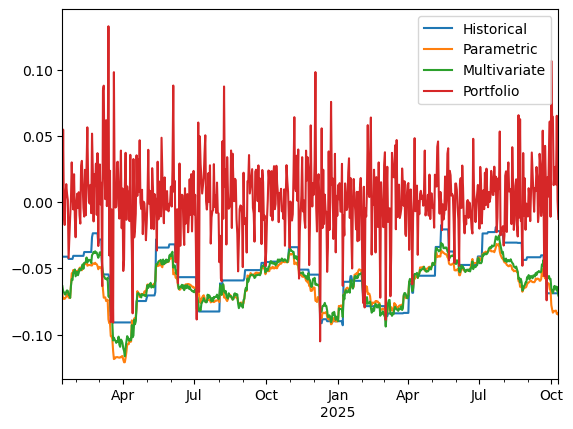

In [155]:
var_data.plot()
plt.show()

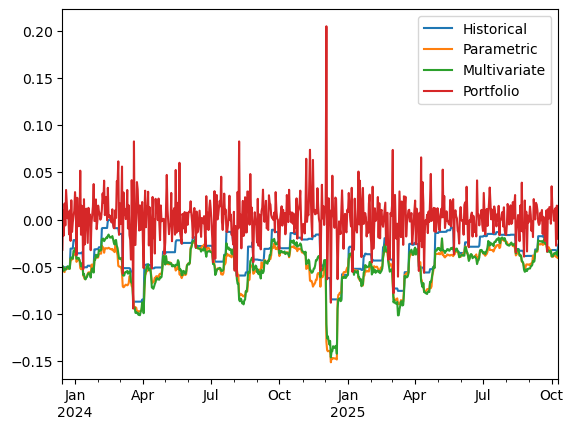

In [156]:
current_var_data.plot()
plt.show()


In [157]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.037736,0.014151,0.017296
Kupiec Stat,2.192467,23.729404,18.953414
P-value,0.138687,0.000001,0.000013


In [158]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.069069,0.013514,0.007508
Kupiec Stat,4.580374,25.971571,38.886172
P-value,0.03234,0.0,0.0


# Principal Component Analysis

## Historical PCA

In [161]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.81568705, 0.07222576, 0.04360268, 0.03586286, 0.03262165])

In [162]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.021955
ADAUSDT      0.020782
ALGOUSDT     0.023885
APTUSDT      0.020645
ARBUSDT      0.030078
ATOMUSDT     0.018527
AVAXUSDT     0.021949
BCHUSDT      0.011362
BNBUSDT      0.010272
BONKUSDT     0.028932
BTCUSDT      0.007869
CAKEUSDT     0.018241
CRVUSDT      0.024417
DOGEUSDT     0.025460
DOTUSDT      0.021630
ETCUSDT      0.020421
ETHUSDT      0.019380
FDUSDUSDT    0.000099
FETUSDT      0.022336
FILUSDT      0.021308
FLOKIUSDT    0.029154
HBARUSDT     0.023434
ICPUSDT      0.021018
IMXUSDT      0.029326
INJUSDT      0.028331
LDOUSDT      0.028262
LINKUSDT     0.024472
LTCUSDT      0.015063
NEARUSDT     0.024765
NEXOUSDT     0.007828
OMUSDT       0.024541
OPUSDT       0.028373
PAXGUSDT     0.000003
PEPEUSDT     0.026526
QNTUSDT      0.017056
SEIUSDT      0.026857
SHIBUSDT     0.019354
SOLUSDT      0.021316
STXUSDT      0.023636
SUIUSDT      0.024937
TRXUSDT      0.006106
UNIUSDT      0.023289
USDCUSDT    -0.000022
VETUSDT      0.020490
WBETHUSDT    0.019343
WBTCUSDT  

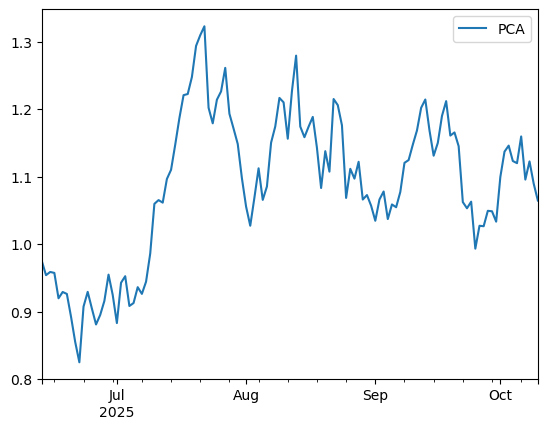

In [163]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

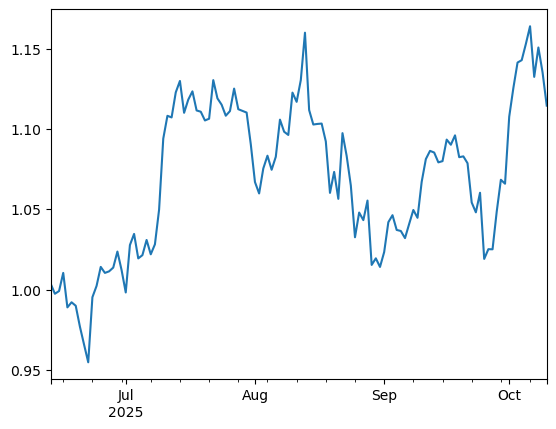

In [164]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [165]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
SHIBUSDT     0.119853
DOTUSDT      0.123600
ICPUSDT      0.129537
VETUSDT      0.133102
FILUSDT      0.133684
STXUSDT      0.142581
ATOMUSDT     0.148000
ADAUSDT      0.177681
PEPEUSDT     0.179729
WBETHUSDT    0.183468
ETHUSDT      0.183738
NEARUSDT     0.194261
DOGEUSDT     0.195124
ETCUSDT      0.195995
SOLUSDT      0.200395
INJUSDT      0.210409
FETUSDT      0.213364
SUIUSDT      0.215225
AAVEUSDT     0.217862
dtype: float64

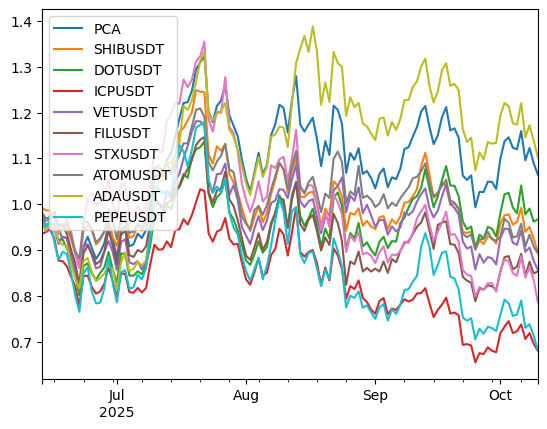

In [166]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

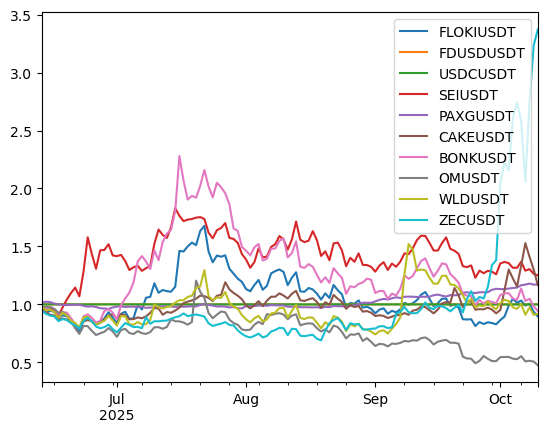

In [167]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [169]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.73314943, 0.1709229 , 0.04159908, 0.02951277, 0.02481582])

In [170]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT     0.059679
TRXUSDT     0.046726
OMUSDT      0.264425
ETHUSDT     0.158004
SOLUSDT     0.171579
BNBUSDT     0.085833
PEPEUSDT    0.214585
PAXGUSDT   -0.000831
Name: PC1, dtype: float64

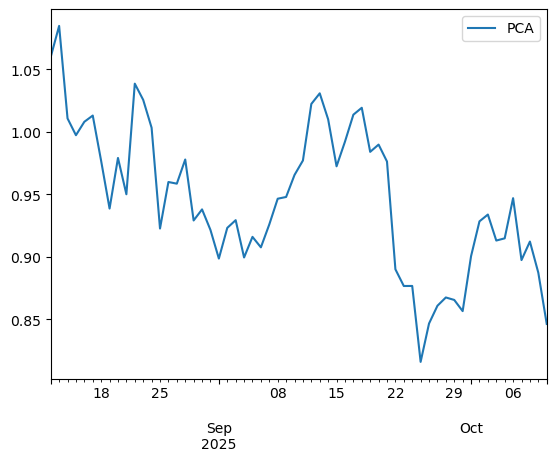

In [171]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA.iloc[-60:]).cumprod().plot()
plt.show()

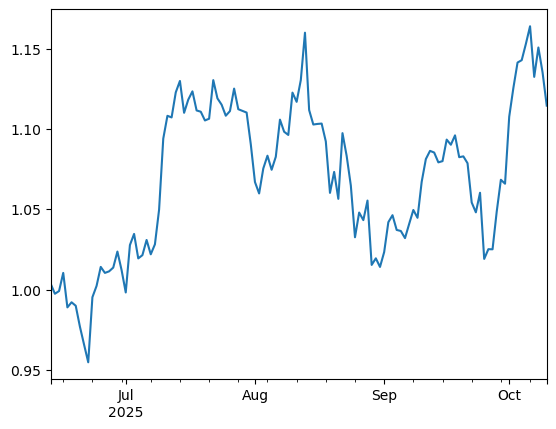

In [172]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [173]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA         0.000000
ETHUSDT     0.196045
PEPEUSDT    0.210487
SOLUSDT     0.223135
BTCUSDT     0.281268
BNBUSDT     0.292135
TRXUSDT     0.323822
OMUSDT      0.377473
PAXGUSDT    0.390025
dtype: float64

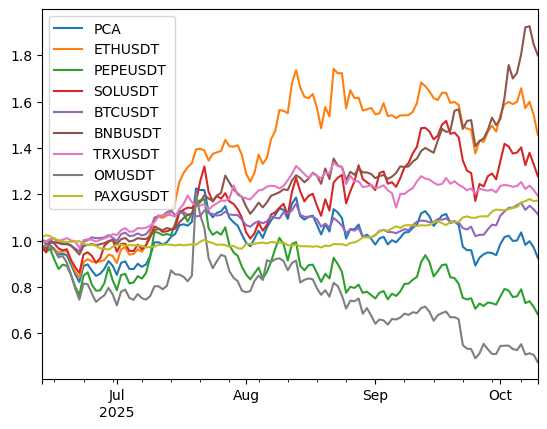

In [174]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [176]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT    1.921161
SOLUSDT     1.311736
ETHUSDT     1.118441
OMUSDT      1.026583
BTCUSDT     1.000000
BNBUSDT     0.679150
TRXUSDT     0.345596
PAXGUSDT    0.029321
Name: BTCUSDT, dtype: float64

In [177]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

SOLUSDT     2.011305
OMUSDT      1.896815
PEPEUSDT    1.811378
ETHUSDT     1.688874
BNBUSDT     1.123939
BTCUSDT     1.000000
TRXUSDT     0.612546
PAXGUSDT   -0.015318
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [179]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [180]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BTCUSDT,0.533970
PEPEUSDT,0.326359
TRXUSDT,0.273122
SOLUSDT,0.244309
OMUSDT,0.109759
BNBUSDT,0.084429
ETHUSDT,-0.205763
PAXGUSDT,-0.229556


### Regression to PCA

In [182]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.9376513459131053

In [183]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

PCA         1.000000
ETHUSDT     0.866237
BNBUSDT     0.757682
BTCUSDT     0.725693
SOLUSDT     0.609753
PEPEUSDT    0.300470
TRXUSDT     0.276031
OMUSDT      0.133978
PAXGUSDT    0.002611
dtype: float64

In [184]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

TRXUSDT     1.880243
BTCUSDT     1.739777
PCA         1.000000
ETHUSDT     0.939649
SOLUSDT     0.791386
PEPEUSDT    0.766855
OMUSDT      0.534004
BNBUSDT     0.493784
PAXGUSDT   -1.259108
dtype: float64

### Correlation Matrix

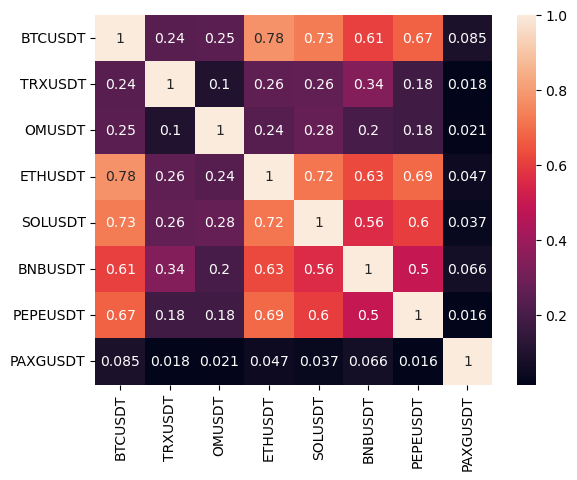

In [186]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

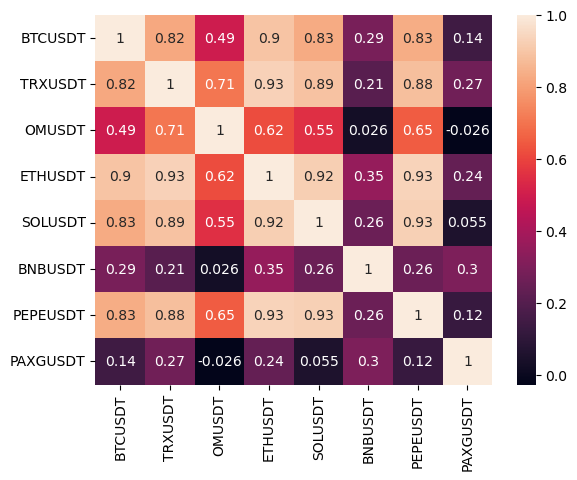

In [187]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [188]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [189]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

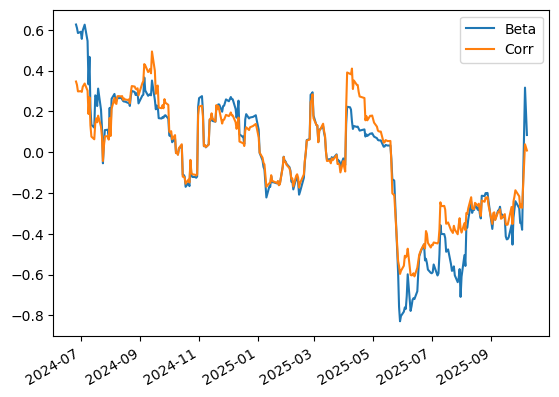

In [190]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [192]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,TRXUSDT,OMUSDT,ETHUSDT,SOLUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2023-12-14,0.107613,0.000000,0.104338,0.000000,0.000000,0.522522,0.000000,0.265527
2023-12-28,0.000000,0.000000,0.000000,0.000000,0.331762,0.668238,0.000000,0.000000
2024-01-11,0.000000,0.000000,0.560261,0.439739,0.000000,0.000000,0.000000,0.000000
2024-01-25,0.000000,0.379495,0.104623,0.000000,0.000000,0.000000,0.000000,0.515881
2024-02-08,0.000000,0.066364,0.047113,0.191143,0.041760,0.000000,0.000000,0.653620
2024-02-22,0.000000,0.705974,0.000000,0.164223,0.000000,0.129803,0.000000,0.000000
2024-03-07,0.000000,0.000000,0.000000,0.020832,0.156080,0.000000,0.046602,0.776486
2024-03-21,0.000000,0.000000,0.462471,0.000000,0.000000,0.471815,0.065714,0.000000
2024-04-04,0.000920,0.000000,0.019296,0.000000,0.000000,0.113904,0.000000,0.865879
2024-04-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [193]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

In [194]:
for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit[0]]-0.0},
                                                                    {'type': 'eq', 'fun': lambda weights: weights[limit[1]]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,ZECUSDT
2025-03-04,0.000000,0.828107,0.008285,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000
2025-04-03,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.268854
2025-05-03,0.000000,0.000000,0.000003,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000524,...,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000
2025-06-02,0.289549,0.028036,0.028137,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.429599
2025-07-02,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.80645,0.000000,0.000000,...,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000
2025-08-01,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.058960,...,0.45687,0.0,0.0,0.0,0.318243,0.0,0.00000,0.080525,0.0,0.000000
2025-08-31,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.0,0.0,0.0,0.014126,0.0,0.00000,0.000000,0.0,0.000000
2025-09-30,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.225231,0.00000,0.000000,0.000000,...,0.00000,0.0,0.0,0.0,0.000000,0.0,0.03162,0.000000,0.0,0.580414
2025-10-10,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.579193,0.000000,...,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.108806


In [195]:
rolling_optimization.iloc[-2].sort_values(ascending=False)[:6]

ZECUSDT     0.580414
AVAXUSDT    0.225231
IMXUSDT     0.162735
WLDUSDT     0.031620
SOLUSDT     0.000000
NEARUSDT    0.000000
Name: 2025-09-30 00:00:00, dtype: float64

In [196]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
